In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse 
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
wheat = pd.read_csv("data/crop/national_yield_with_trend.csv")
weather = pd.read_csv("data/weather_features_era.csv")

x_y_cv = weather.merge(wheat[["year", "yield [kg/ha]"]], on="year")
x_y_cv.head()

,year,rain_1,rain_2,rain_3,rain_4,rain_5,rain_6,rain_7,rain_8,rain_9,...,tmean_4,tmean_5,tmean_6,tmean_7,tmean_8,tmean_9,tmean_10,tmean_11,tmean_12,yield [kg/ha]
0,1993,40.71,14.65,26.11,44.73,29.22,15.44,3.81,8.18,15.12,...,16.99,12.73,10.11,7.93,11.48,12.88,17.09,18.93,21.99,2032.688963
1,1994,24.52,23.60,25.93,19.45,27.44,10.05,9.29,15.52,15.73,...,16.37,14.83,11.81,9.28,11.20,14.70,16.24,20.68,24.81,2186.156810
2,1995,23.68,22.83,25.85,30.66,8.31,5.46,3.23,3.59,8.35,...,16.66,13.56,10.19,9.10,11.05,14.96,16.62,21.16,24.75,1948.981571
3,1996,28.57,36.80,15.62,44.03,11.53,6.63,4.98,14.15,16.54,...,16.87,14.49,9.11,8.64,14.06,13.87,17.90,21.27,22.66,2264.585949
4,1997,34.53,24.41,17.71,12.29,11.64,18.78,10.52,14.06,11.34,...,18.73,15.86,11.11,12.10,12.60,14.08,16.53,19.38,21.47,2617.581694


In [70]:
years_to_params = {}
for year in x_y_cv["year"].unique().tolist(): years_to_params[year] = {"slope":np.nan, "bias":np.nan}

for year in x_y_cv["year"].unique().tolist():
    year_range = wheat.loc[wheat["year"].isin(list(range(year-24, year))), ["year", "yield [kg/ha]"]]
    (slope, bias), (current_error,), *_ = np.polyfit(year_range["year"], year_range["yield [kg/ha]"], deg=1, full=True)
    years_to_params[year]["slope"] = slope
    years_to_params[year]["bias"] = bias


371.5


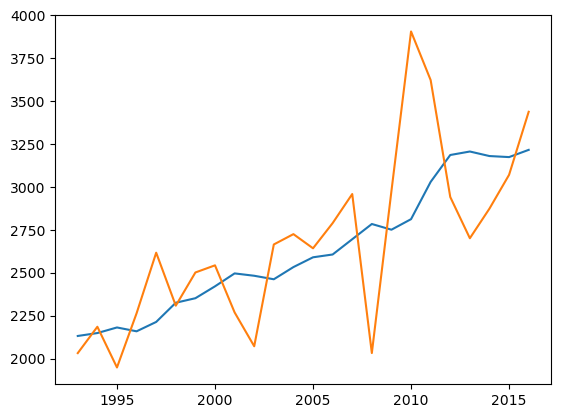

In [71]:
trend_estimated = []

for year in x_y_cv["year"].unique().tolist():
    value = year * years_to_params[year]["slope"] + years_to_params[year]["bias"]
    trend_estimated.append(value)
    
plt.plot(x_y_cv["year"].unique().tolist(), trend_estimated)
plt.plot(x_y_cv["year"].unique().tolist(), x_y_cv["yield [kg/ha]"])

print(np.round(mse(trend_estimated, x_y_cv["yield [kg/ha]"].values.tolist(), squared=False), 2))

In [75]:
x_y_cv["yield_trend [kg/ha]"] = trend_estimated
x_y_cv["yield anomaly [kg/ha]"] = x_y_cv["yield [kg/ha]"] - x_y_cv["yield_trend [kg/ha]"]

rmse is 400.79 and pearson's r is 0.28


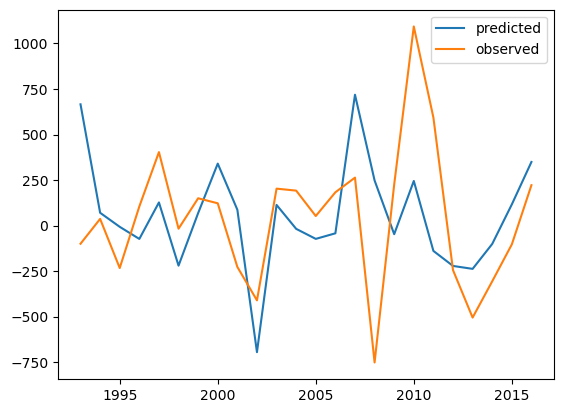

In [99]:
X = x_y_cv.loc[:, [c for c in x_y_cv.columns if c not in ["year", "yield [kg/ha]", "yield_trend [kg/ha]", "yield anomaly [kg/ha]"]]]
y = x_y_cv["yield anomaly [kg/ha]"]

pipeline = Pipeline([('scaler', StandardScaler()), 
                             ('var', VarianceThreshold()), 
                             ('selector', SelectKBest(f_regression, k=9)),
                             ('estimator', Ridge())])

# Perform LOOCV and obtain predictions
loo = LeaveOneOut()
y_pred = cross_val_predict(pipeline, X, y, cv=loo)

rmse = np.round(mse(y_pred, y, squared=False), 2)
r = np.round(pearsonr(y_pred, y)[0], 2)
print("rmse is {} and pearson's r is {}".format(rmse, r))

plt.plot(x_y_cv["year"], y_pred, label="predicted");
plt.plot(x_y_cv["year"], y, label="observed");
plt.legend();

### Get rid of months outside crop season and during planting

rmse is 416.7 and pearson's r is 0.14


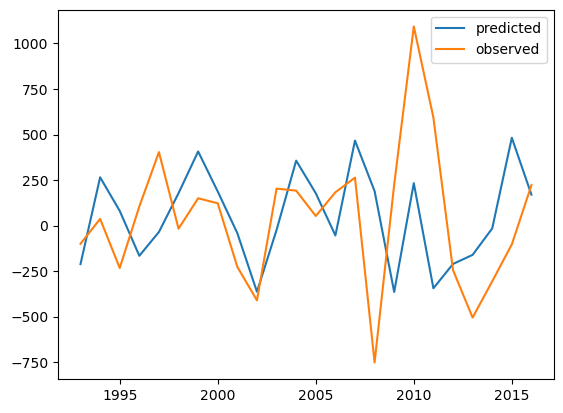

In [133]:

X = x_y_cv.loc[:, [c for c in x_y_cv.columns if  ("_9" in c) or ("_10" in c) or ("_11" in c)]]
y = x_y_cv["yield anomaly [kg/ha]"]

pipeline = Pipeline([('scaler', StandardScaler()), 
                             ('var', VarianceThreshold()), 
                             ('selector', SelectKBest(f_regression, k=6)),
                             ('estimator', Ridge())])

# Perform LOOCV and obtain predictions
loo = LeaveOneOut()
y_pred = cross_val_predict(pipeline, X, y, cv=loo)

rmse = np.round(mse(y_pred, y, squared=False), 2)
r = np.round(pearsonr(y_pred, y)[0], 2)
print("rmse is {} and pearson's r is {}".format(rmse, r))

plt.plot(x_y_cv["year"], y_pred, label="predicted");
plt.plot(x_y_cv["year"], y, label="observed");
plt.legend();

rmse is 369.83 and pearson's r is 0.24


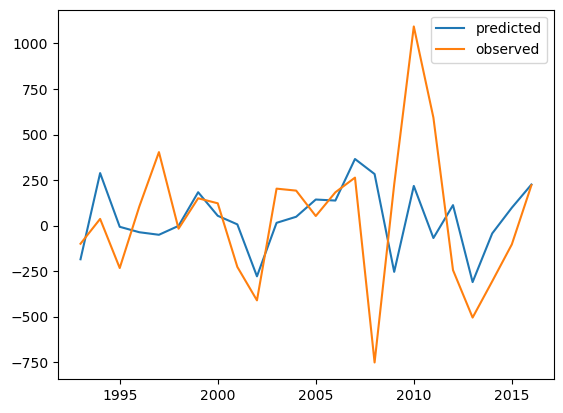

In [194]:
X = x_y_cv.loc[:, [c for c in x_y_cv.columns if  ("_9" in c) or ("_10" in c) or ("_11" in c)]]
y = x_y_cv["yield anomaly [kg/ha]"]

pipeline = Pipeline([('polynomial_features', PolynomialFeatures(3, interaction_only=True)),
                    ('scaler', StandardScaler()), 
                    ('var', VarianceThreshold()), 
                    ('selector', SelectKBest(f_regression, k=3)),
                    ('estimator', Ridge())])

# Perform LOOCV and obtain predictions
loo = LeaveOneOut()
y_pred = cross_val_predict(pipeline, X, y, cv=loo)

rmse = np.round(mse(y_pred, y, squared=False), 2)
r = np.round(pearsonr(y_pred, y)[0], 2)
print("rmse is {} and pearson's r is {}".format(rmse, r))

plt.plot(x_y_cv["year"], y_pred, label="predicted");
plt.plot(x_y_cv["year"], y, label="observed");
plt.legend();

In [195]:
X = x_y_cv.loc[:, [c for c in x_y_cv.columns if  ("_9" in c) or ("_10" in c) or ("_11" in c)]]
y = x_y_cv["yield anomaly [kg/ha]"]

pipeline = Pipeline([('polynomial_features', PolynomialFeatures(3, interaction_only=True)),
                    ('scaler', StandardScaler()), 
                    ('var', VarianceThreshold()), 
                    ('selector', SelectKBest(f_regression, k=3)),
                    ('estimator', Ridge())])

# Perform LOOCV and obtain predictions
loo = LeaveOneOut()
y_pred = cross_val_predict(pipeline, X, y, cv=loo)


x_y_cv["var_predicted"] = y_pred

In [200]:
x_y_cv["absolute yield prediction"] = x_y_cv[["year", "var_predicted"]].apply(lambda x: x[0] * years_to_params[x[0]]["slope"] + years_to_params[x[0]]["bias"] + x[1], axis=1)

rmse is 369.83


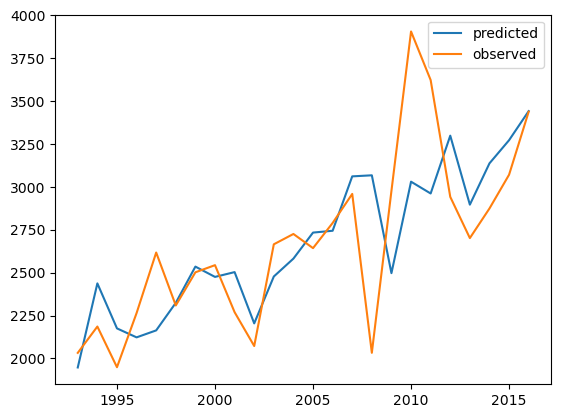

In [202]:
rmse = np.round(mse(x_y_cv["absolute yield prediction"], x_y_cv["yield [kg/ha]"], squared=False), 2)
#r = np.round(pearsonr(x_y_cv["absolute yield prediction"], x_y_cv["yield [kg/ha]"])[0], 2)
print("rmse is {}".format(rmse))

plt.plot(x_y_cv["year"], x_y_cv["absolute yield prediction"], label="predicted");
plt.plot(x_y_cv["year"], x_y_cv["yield [kg/ha]"], label="observed");
plt.legend();